In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset
df = pd.read_csv('Global_Pollution_Analysis.csv')

# Handle missing values
imputer = SimpleImputer(strategy='mean')
pollution_cols = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
df[pollution_cols] = imputer.fit_transform(df[pollution_cols])

# Data transformation: Normalize pollution indices
scaler = StandardScaler()
df[pollution_cols] = scaler.fit_transform(df[pollution_cols])

# Encode categorical features
categorical_cols = ['Country', 'Year']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

Descriptive Statistics:
        CO2_Emissions (in MT)  Industrial_Waste (in tons)
count             200.000000                   200.00000
mean               24.878100                 52891.68150
std                14.470892                 27224.49169
min                 1.920000                  1019.37000
25%                11.220000                 31201.97250
50%                25.355000                 55299.15000
75%                38.550000                 74805.82500
max                49.690000                 99739.36000


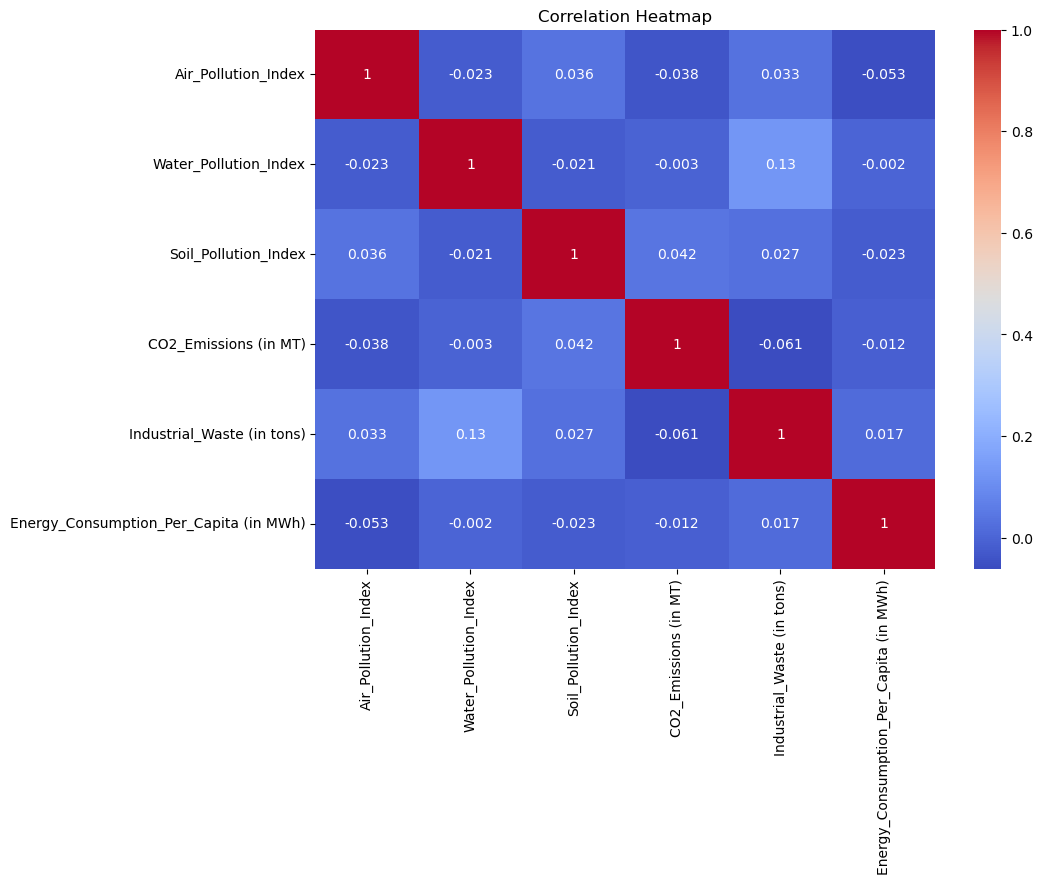

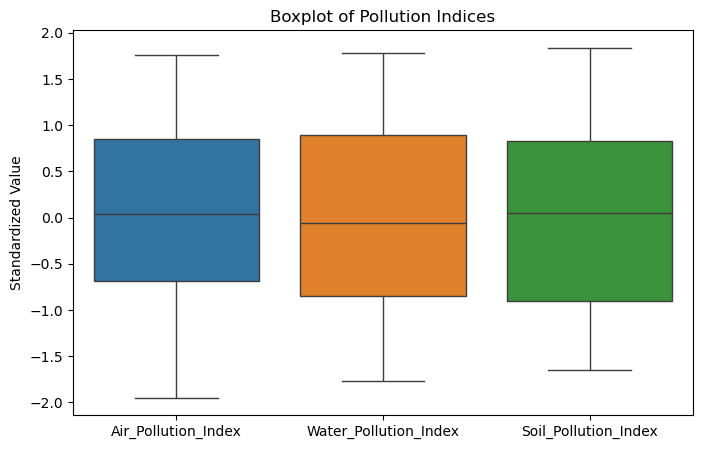

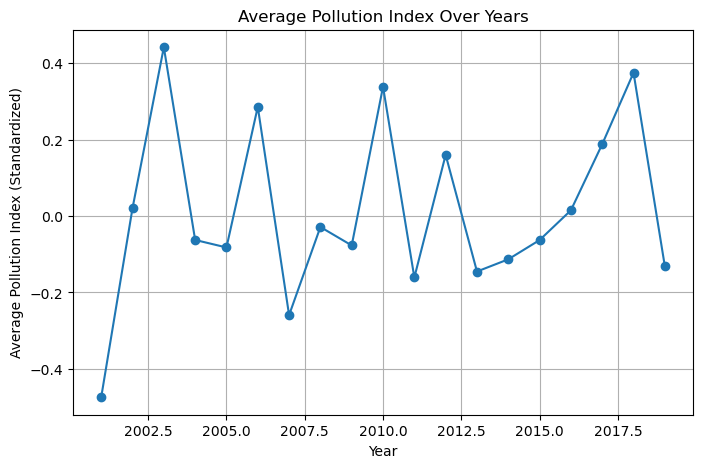

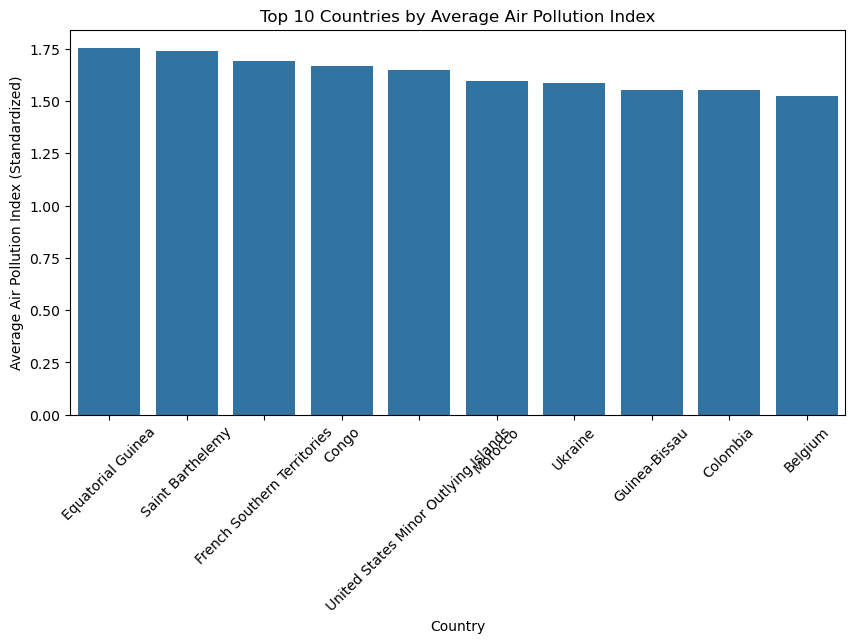

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

# Descriptive Statistics for numerical features
desc_stats = df[['CO2_Emissions (in MT)', 'Industrial_Waste (in tons)']].describe()
print("Descriptive Statistics:\n", desc_stats)

# Correlation Analysis: pollution levels vs. other features
corr_features = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index',
                 'CO2_Emissions (in MT)', 'Industrial_Waste (in tons)', 'Energy_Consumption_Per_Capita (in MWh)']
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Visualizations

# Box plot: Pollution indices
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']])
plt.title('Boxplot of Pollution Indices')
plt.ylabel('Standardized Value')
plt.show()

# Line plot: Average pollution over years
year_cols = [col for col in df.columns if col.startswith('Year_')]
years = [int(col.split('_')[1]) for col in year_cols]
avg_pollution_by_year = []
for i, year_col in enumerate(year_cols):
    indices = df[year_col] == 1
    avg_pollution_by_year.append(df.loc[indices, ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']].mean().mean())

plt.figure(figsize=(8, 5))
plt.plot(years, avg_pollution_by_year, marker='o')
plt.title('Average Pollution Index Over Years')
plt.xlabel('Year')
plt.ylabel('Average Pollution Index (Standardized)')
plt.grid(True)
plt.show()

# Bar chart: Top 10 countries by average Air Pollution Index
country_cols = [col for col in df.columns if col.startswith('Country_')]
country_means = {}
for col in country_cols:
    indices = df[col] == 1
    country_means[col.replace('Country_', '')] = df.loc[indices, 'Air_Pollution_Index'].mean()
top_countries = sorted(country_means.items(), key=lambda x: x[1], reverse=True)[:10]
countries, values = zip(*top_countries)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(countries), y=list(values))
plt.title('Top 10 Countries by Average Air Pollution Index')
plt.ylabel('Average Air Pollution Index (Standardized)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Yearly Trends: Calculate yearly averages for pollution indices and energy recovery
yearly_trends = []
for i, year_col in enumerate(year_cols):
    indices = df[year_col] == 1
    avg_air = df.loc[indices, 'Air_Pollution_Index'].mean()
    avg_water = df.loc[indices, 'Water_Pollution_Index'].mean()
    avg_soil = df.loc[indices, 'Soil_Pollution_Index'].mean()
    avg_energy_recovery = df.loc[indices, 'Energy_Recovered (in GWh)'].mean()
    yearly_trends.append({
        'Year': years[i],
        'Avg_Air_Pollution': avg_air,
        'Avg_Water_Pollution': avg_water,
        'Avg_Soil_Pollution': avg_soil,
        'Avg_Energy_Recovery': avg_energy_recovery
    })
yearly_trends_df = pd.DataFrame(yearly_trends)

# Energy Consumption per Capita: Calculate and add as a new column if not already present
if 'Energy_Consumption_Per_Capita (in MWh)' not in df.columns and \
   'Energy_Consumption (in MWh)' in df.columns and \
   'Population (in millions)' in df.columns:
    df['Energy_Consumption_Per_Capita (in MWh)'] = (
        df['Energy_Consumption (in MWh)'] / (df['Population (in millions)'] * 1e6)
    )

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Air_Pollution_Index', 'CO2_Emissions (in MT)', 'Industrial_Waste (in tons)']
X = df[features]
y = df['Energy_Recovered (in GWh)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

R²: -0.0252
Mean Squared Error (MSE): 24792.81
Mean Absolute Error (MAE): 142.11


Accuracy: 0.950
Precision: 0.956
Recall: 0.950
F1-score: 0.949


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


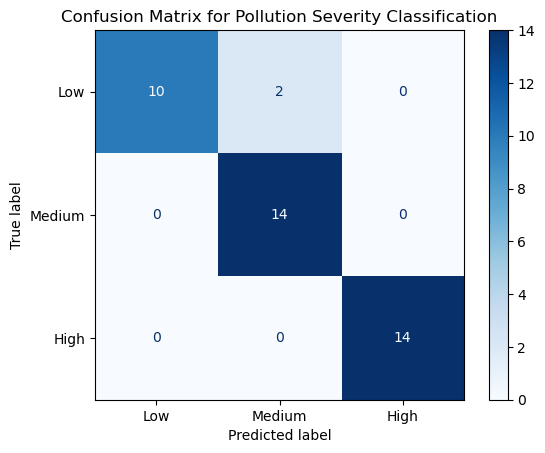

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Create pollution severity categories based on Air_Pollution_Index
# Low: < -0.5, Medium: -0.5 to 0.5, High: > 0.5 (since standardized)
def categorize_severity(x):
    if x < -0.5:
        return 0  # Low
    elif x > 0.5:
        return 2  # High
    else:
        return 1  # Medium

df['Pollution_Severity'] = df['Air_Pollution_Index'].apply(categorize_severity)

# Features and target for classification
X_cls = df[['Air_Pollution_Index', 'CO2_Emissions (in MT)']]
y_cls = df['Pollution_Severity']

# Train-test split
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Logistic Regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logreg.fit(X_train_cls, y_train_cls)

# Predictions
y_pred_cls = logreg.predict(X_test_cls)

# Evaluation metrics
acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls, average='weighted')
rec = recall_score(y_test_cls, y_pred_cls, average='weighted')
f1 = f1_score(y_test_cls, y_pred_cls, average='weighted')

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Pollution Severity Classification')
plt.show()

Linear Regression Performance:
R²: -0.0252
Mean Squared Error (MSE): 24792.81
Mean Absolute Error (MAE): 142.11

Logistic Regression Performance:
Accuracy: 0.950
Precision: 0.956
Recall: 0.950
F1-score: 0.949

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         Low       1.00      0.83      0.91        12
      Medium       0.88      1.00      0.93        14
        High       1.00      1.00      1.00        14

    accuracy                           0.95        40
   macro avg       0.96      0.94      0.95        40
weighted avg       0.96      0.95      0.95        40



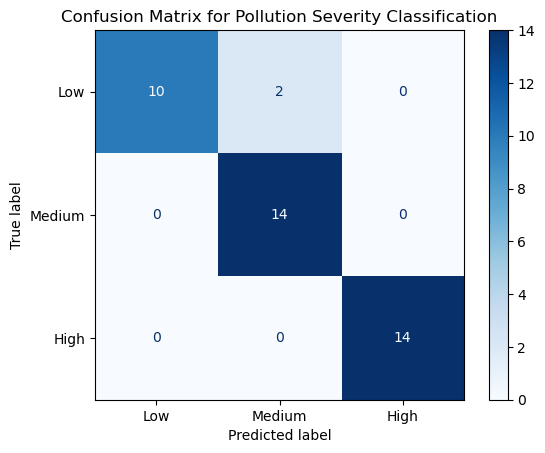

In [7]:
from sklearn.metrics import classification_report

# Linear Regression metrics (already printed in cell 3)
print("Linear Regression Performance:")
print(f"R²: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}\n")

# Logistic Regression metrics (already printed in cell 4)
print("Logistic Regression Performance:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}\n")

# Classification report for Logistic Regression
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_cls, y_pred_cls, target_names=['Low', 'Medium', 'High']))

# Confusion Matrix visualization (already created as 'disp')
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Pollution Severity Classification')
plt.show()

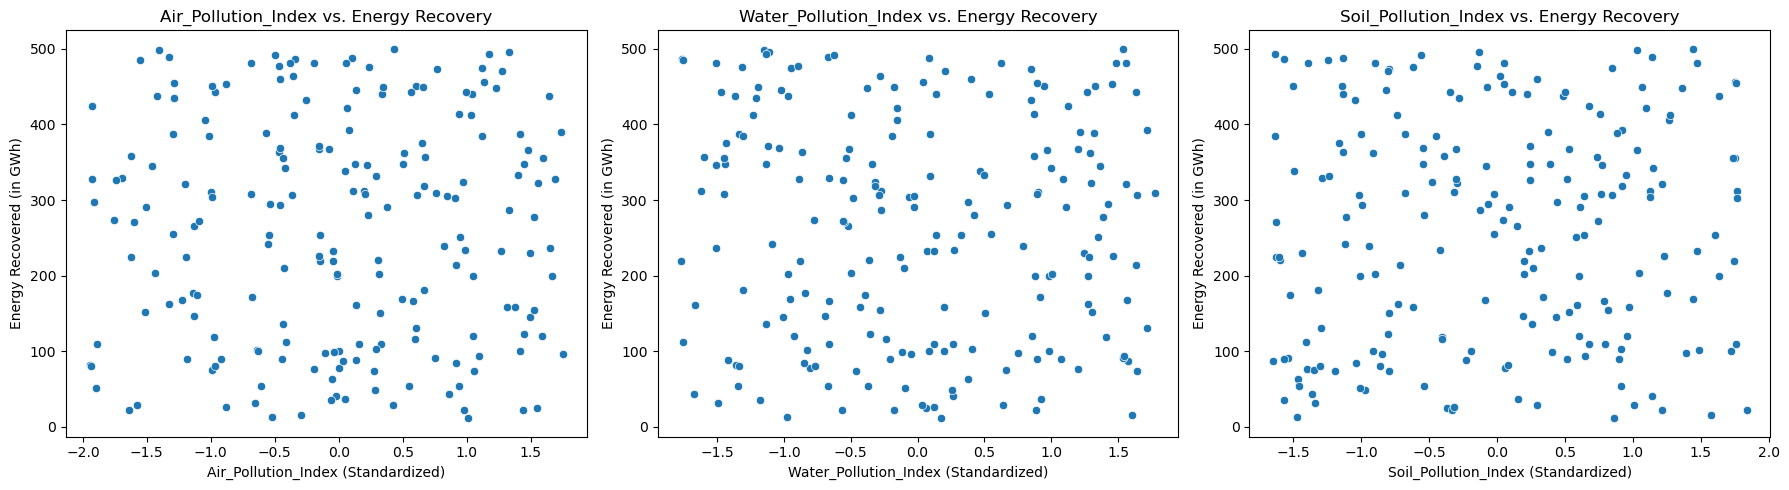

Average Energy Recovery by Pollution Severity:
Severity_Label
High      263.610588
Low       249.703607
Medium    266.652113
Name: Energy_Recovered (in GWh), dtype: float64

Countries with high air pollution but below-median energy recovery (could benefit from improvement):
Bolivia: Air Pollution Index=1.09, Energy Recovery=93.73
British Indian Ocean Territory (Chagos Archipelago): Air Pollution Index=0.58, Energy Recovery=166.16
Cambodia: Air Pollution Index=1.45, Energy Recovery=123.15
Christmas Island: Air Pollution Index=0.98, Energy Recovery=22.21
Colombia: Air Pollution Index=1.55, Energy Recovery=24.45
Congo: Air Pollution Index=1.67, Energy Recovery=199.71
Cook Islands: Air Pollution Index=1.49, Energy Recovery=145.18
Equatorial Guinea: Air Pollution Index=1.75, Energy Recovery=96.77
Gambia: Air Pollution Index=0.92, Energy Recovery=84.46
Gibraltar: Air Pollution Index=0.61, Energy Recovery=130.40
Hungary: Air Pollution Index=1.38, Energy Recovery=158.14
Indonesia: Air Pollutio

In [8]:
import seaborn as sns

# Insights on pollution levels and energy recovery

# 1. Relationship between pollution indices and energy recovery
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pollution_labels = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']

for i, col in enumerate(pollution_labels):
    sns.scatterplot(
        x=df[col],
        y=df['Energy_Recovered (in GWh)'],
        ax=axes[i]
    )
    axes[i].set_title(f'{col} vs. Energy Recovery')
    axes[i].set_xlabel(f'{col} (Standardized)')
    axes[i].set_ylabel('Energy Recovered (in GWh)')

plt.tight_layout()
plt.show()

# 2. Average energy recovery by pollution severity
severity_map = {0: 'Low', 1: 'Medium', 2: 'High'}
df['Severity_Label'] = df['Pollution_Severity'].map(severity_map)
avg_energy_by_severity = df.groupby('Severity_Label')['Energy_Recovered (in GWh)'].mean()
print("Average Energy Recovery by Pollution Severity:")
print(avg_energy_by_severity)

# 3. Suggest countries that could benefit from improvement
# Find countries with high pollution but below-median energy recovery
country_cols = [col for col in df.columns if col.startswith('Country_')]
country_names = [col.replace('Country_', '') for col in country_cols]
results = []

for col, name in zip(country_cols, country_names):
    indices = df[col] == 1
    avg_air = df.loc[indices, 'Air_Pollution_Index'].mean()
    avg_energy = df.loc[indices, 'Energy_Recovered (in GWh)'].mean()
    results.append((name, avg_air, avg_energy))

# Filter: high air pollution (>0.5) and below-median energy recovery
median_energy = df['Energy_Recovered (in GWh)'].median()
suggested = [(name, air, energy) for name, air, energy in results if air > 0.5 and energy < median_energy]

print("\nCountries with high air pollution but below-median energy recovery (could benefit from improvement):")
for name, air, energy in suggested:
    print(f"{name}: Air Pollution Index={air:.2f}, Energy Recovery={energy:.2f}")

In [9]:
# Recommendations for reducing pollution and improving energy recovery

print("Recommendations for Reducing Pollution and Improving Energy Recovery:\n")

# 1. Target countries with high pollution and low energy recovery
print("1. Focus on countries with high air pollution but below-median energy recovery:")
for name, air, energy in suggested:
    print(f"   - {name}: Air Pollution Index={air:.2f}, Energy Recovery={energy:.2f}")

print("\n2. Recommendations:")
print("- Invest in advanced waste-to-energy technologies to convert more waste into usable energy, especially in countries identified above.")
print("- Implement stricter regulations and incentives for industrial emission reductions and cleaner production processes.")
print("- Promote the adoption of renewable energy sources and improve energy efficiency in industrial and residential sectors.")
print("- Encourage recycling and circular economy practices to reduce waste generation and resource consumption.")
print("- Enhance public awareness and education on pollution prevention and sustainable energy use.")
print("- Strengthen monitoring and reporting systems for pollution and energy recovery to track progress and identify further opportunities for improvement.")

Recommendations for Reducing Pollution and Improving Energy Recovery:

1. Focus on countries with high air pollution but below-median energy recovery:
   - Bolivia: Air Pollution Index=1.09, Energy Recovery=93.73
   - British Indian Ocean Territory (Chagos Archipelago): Air Pollution Index=0.58, Energy Recovery=166.16
   - Cambodia: Air Pollution Index=1.45, Energy Recovery=123.15
   - Christmas Island: Air Pollution Index=0.98, Energy Recovery=22.21
   - Colombia: Air Pollution Index=1.55, Energy Recovery=24.45
   - Congo: Air Pollution Index=1.67, Energy Recovery=199.71
   - Cook Islands: Air Pollution Index=1.49, Energy Recovery=145.18
   - Equatorial Guinea: Air Pollution Index=1.75, Energy Recovery=96.77
   - Gambia: Air Pollution Index=0.92, Energy Recovery=84.46
   - Gibraltar: Air Pollution Index=0.61, Energy Recovery=130.40
   - Hungary: Air Pollution Index=1.38, Energy Recovery=158.14
   - Indonesia: Air Pollution Index=0.62, Energy Recovery=243.67
   - Kyrgyz Republic: Air P